In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
#%matplotlib notebook
%matplotlib inline
import torch.nn as nn, timeit, torch, pystan as ps
from time import time
import matplotlib.pyplot as plt
from pylab import plot, show, legend

In [3]:
sm_refpoints = ps.StanModel(file="stan_files/nn_refpoints.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6f58d235465c773e740a890b0262cc7f NOW.


In [4]:
M = 1000
X = 10*npr.rand(2,M)
Y = np.zeros((3,M))
Y[0] = np.cos(X[0])*np.cos(X[1])
Y[1] = np.cos(X[0])*np.sin(X[1])
Y[2] = np.sin(X[0])

idx = Y[2]>0
Y = Y[:,idx]
X = X[:,idx]
Y += 0.1*npr.rand(*np.shape(Y))
Nobs = np.shape(X)[1]

### Local linear embedding for reference points:

In [5]:
n_ref = 100
ref_points = npr.choice(Nobs,n_ref,replace=False)
embedding = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
Y_embedded = embedding.fit_transform(Y.transpose()).transpose()

In [6]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
Y_ref = Y[:,ref_points]
X_ref = Y_embedded[:,ref_points]
Y_train = Y[:,train]

In [7]:
n_in = np.shape(Y_embedded)[0]
n_out = np.shape(Y)[0]
n_h = 50

In [8]:
data_refpoints = dict(Nobs=Nobs, 
                      in_dim=np.shape(X)[0], 
                      out_dim=np.shape(Y)[0], 
                      hidden_dim=n_h,
                      n_ref=np.shape(Y_ref)[1],
                      y=Y_train, 
                      y_ref=Y_ref,
                      X_ref=X_ref)

### Run Stan:

In [9]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_refpoints_lle = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=4,chains=4,
                                      init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints_lle);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


324.84 minutes to run
Inference for Stan model: anon_model_6f58d235465c773e740a890b0262cc7f.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]              -0.98     0.7   1.03  -2.67  -1.93  -0.74-1.3e-3   0.23      2   4.21
X[2,1]               -0.1    0.83    1.2  -1.51  -1.14  -0.27   0.71   2.14      2   6.41
X[3,1]              -0.25    0.32    0.5  -1.33  -0.56   -0.1   0.16   0.35      2   2.78
X[4,1]               0.38    0.54   0.81  -1.11  -0.25   0.65   0.93   1.45      2   3.19
X[5,1]              -0.11    0.82   1.18  -2.54  -0.83  -0.05   0.52   1.75      2   5.68
X[6,1]               0.31    0.65   0.95  -0.94  -0.56 8.9e-3   1.14   1.96      2   3.87
X[7,1]                0.3    0.29   0.71  -0.79  -0.12   0.08   0.73   2.17      6    2.1
X[8,1]              -0.26    0.52   0.86  -2.08  -0.82  -0.28   0.48   

In [10]:
trace = fit_refpoints_lle.extract()
n_samples = np.shape(trace['X'])[0]
n_latent = np.shape(trace['X'])[1]

### Traceplots of latent variables:

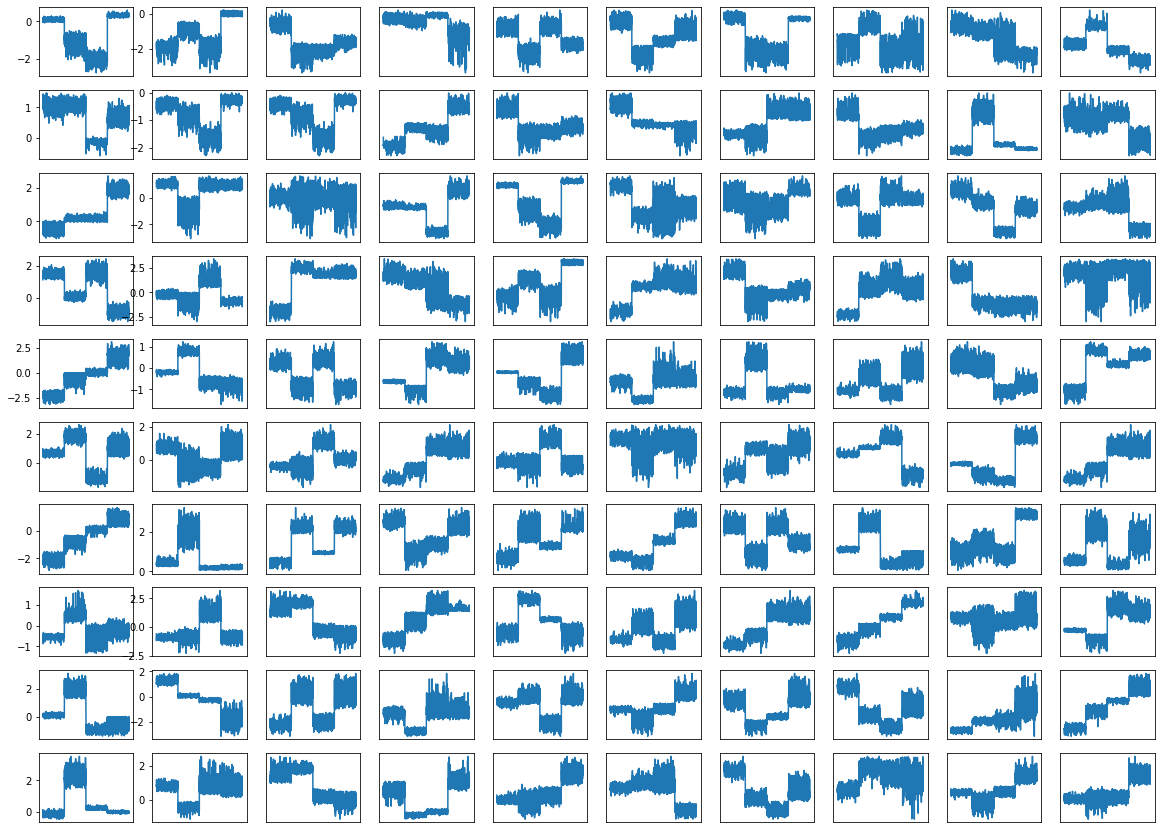

In [11]:
plt.figure(figsize=(20,15))
idx = npr.choice(n_latent,100).reshape(10,10)

for i in range(10):
    for j in range(10):
        k = 10*i+j
        plt.subplot(10,10,k+1)
        plt.plot(trace['X'][:,idx[i,j],0])
        plt.xticks([])
        if j > 1 : plt.yticks([])
plt.show()

### Loss:

100%|██████████| 2000/2000 [00:01<00:00, 1581.82it/s]


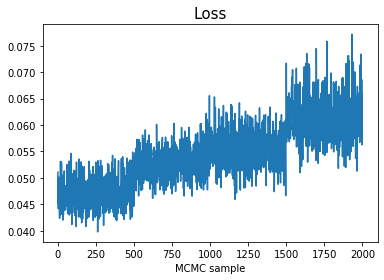

In [13]:
loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(Y_train.transpose(), trace['X'][i], trace['weights_1'][i], 
                      trace['bias_1'][i], trace['weights_2'][i], trace['bias_2'][i])
plt.plot(loss)
plt.title("Loss", fontsize=15)
plt.xlabel("MCMC sample");

### Pairwise distances:

In [14]:
pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for i in trange(100) :
    for j in range(100) :
        for k in range(n_samples) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['X'][k,i]-trace['X'][k,j])

100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


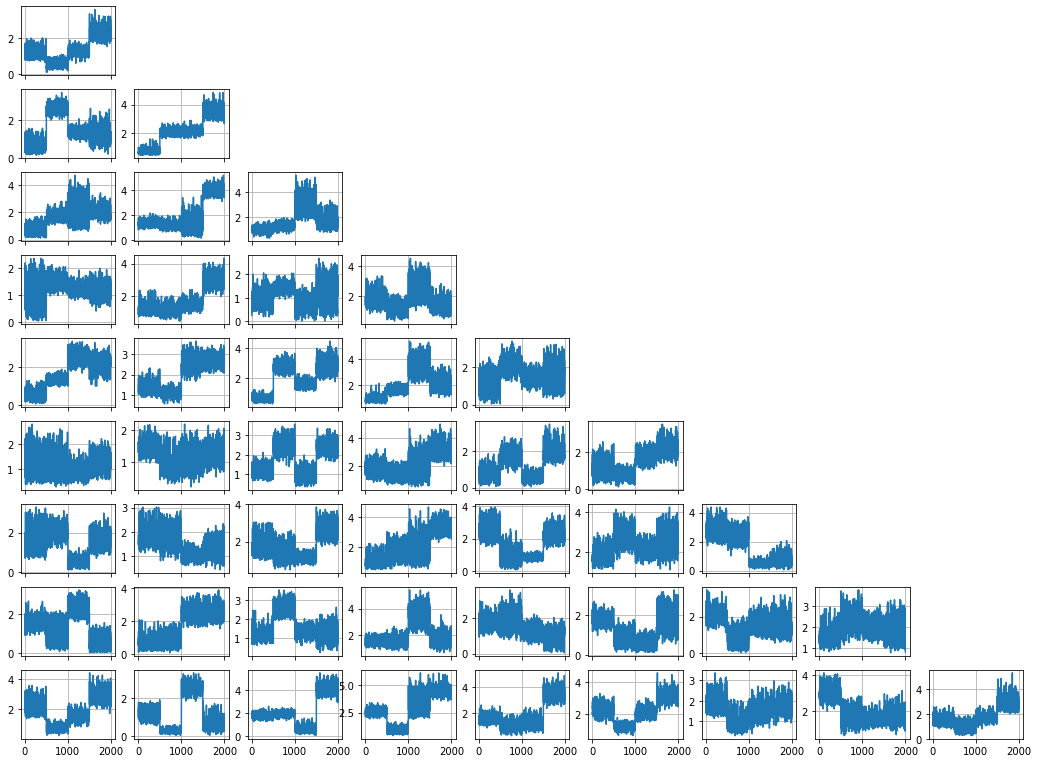

In [15]:
idx = npr.choice(100,10)
plt.figure(figsize=(20,15))
for i in range(10):
    for j in range(10):
        if i > j :
            k = 10*i+j+1
            plt.subplot(10,10,k)
            plt.plot(pw_dist_matrix[idx[i],idx[j]])
            if i < 9 : plt.xticks(alpha=0)
            plt.grid(True)
plt.show()